# Train model with dense neural network approach

## Initialize dataset for model training and evaluation

In [1]:
# control if using sampled or original data
import joblib
from config import TRAIN_TEST_SPLIT_ELECTRIC_FILE, TRAIN_TEST_SPLIT_ELECTRIC_FILE_SAMPLED

is_sampled = True

In [2]:
# load data
if is_sampled:
    X_train, X_test, y_train, y_test = joblib.load(TRAIN_TEST_SPLIT_ELECTRIC_FILE_SAMPLED)
else:
    X_train, X_test, y_train, y_test = joblib.load(TRAIN_TEST_SPLIT_ELECTRIC_FILE)

In [3]:
# temporary reduce the size of the dataset for testing
X_train = X_train[:1000]
y_train = y_train[:1000]
X_test = X_test[:1000]
y_test = y_test[:1000]

In [4]:
# example prints to validate correct output
X_train.head(2)

,member_state_AT,member_state_BE,member_state_BG,member_state_CY,member_state_CZ,member_state_DE,member_state_DK,member_state_EE,member_state_ES,member_state_FI,...,commercial_name_iX3,commercial_name_other,category_of_vehicle_M1,category_of_vehicle_M1,category_of_vehicle_M1G,category_of_vehicle_N1,mass_vehicle,engine_power,year,electric_range
1098489,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.701759,1.150490,-0.231749,0.913368
25173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.959870,1.893266,-1.485252,0.285944


In [5]:
X_train.shape

(1000, 298)

## Train Dense Neural Network model with tensorflow keras

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from config import ELECTRIC_NN_CKPT_MODEL_FILE, ELECTRIC_NN_MODEL_FILE
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [7]:
# Instantiate the model
inputs = Input(shape=(X_train.shape[1],))

# Dense with relu as activation function for regression problem -> Multiple layers but sequentially reducing number of units
# BatchNormalization: Normalizes activations to stabilize training.
# Dropout: Prevents overfitting by randomly disabling neurons.

# x = Dense(128, activation='relu')(inputs)
# x = BatchNormalization()(x)
# x = Dropout(0.2)(x)

# x = Dense(64, activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.2)(x)

x = Dense(64, activation='relu')(inputs)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(32, activation='relu')(x)
outputs = Dense(1)(x)  # Regression -> No activation function

# Create model
model = Model(inputs=inputs, outputs=outputs)

In [8]:
# display model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 298)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        19,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,505 (84.00 KB)

 Trainable params: 21,377 (83.50 KB)

 Non-trainable params: 128 (512.00 B)

In [9]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])
# loss: MSE (Mean Squared Error)
# metric: MAE (Mean Absolute Error)

In [10]:
# Define Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',  # Stop if validation loss stops improving
    patience=5,         # Wait 10 epochs before stopping
    restore_best_weights=True  # Load best weights after stopping
)

model_checkpoint = ModelCheckpoint(
    ELECTRIC_NN_CKPT_MODEL_FILE,  # File to save the best model
    monitor='val_loss',  # Save model when val_loss improves
    save_best_only=True  # Only save the best version
)



In [11]:
# Train the model
model_history = model.fit(
    X_train, y_train,
    epochs=100,  # 50
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 26447.2363 - mae: 160.6347 - val_loss: 20169.7617 - val_mae: 139.0841
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9022.9297 - mae: 82.7116 - val_loss: 1023.2936 - val_mae: 25.8935
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1172.7941 - mae: 25.9738 - val_loss: 473.8758 - val_mae: 17.6569
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 824.6552 - mae: 22.1710 - val_loss: 508.7884 - val_mae: 19.3889
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 748.4513 - mae: 21.2958 - val_loss: 283.5313 - val_mae: 14.6293
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 543.4780 - mae: 18.4605 - val_loss: 159.9381 - val_mae: 9.3765
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 438.4181 - mae: 16.4386 - val_loss: 151.1627 - val_mae: 9.7536
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 399.6278 - mae: 15.6075 - val_loss: 163.5199 - val_mae: 10.4269
Epoch 9/

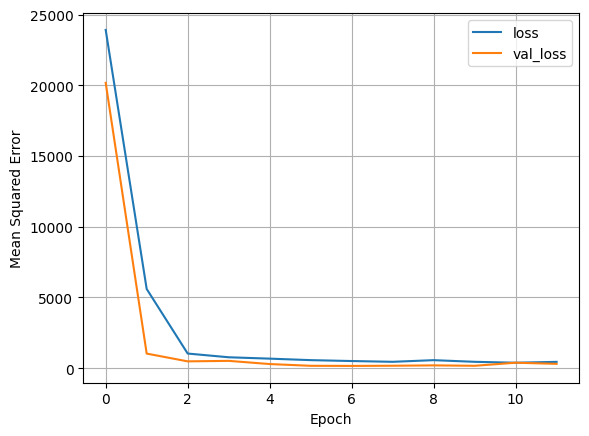

In [12]:
# display loss evolution

def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    # plt.ylim([0,10])
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(model_history)

In [13]:
# Store model
joblib.dump(model, ELECTRIC_NN_MODEL_FILE)

['files/output/models/electric-nn_model.keras']

## Evaluate results of DNN Model

In [14]:
# Evaluate preditions
# test_results = model.evaluate(X_test, y_test, verbose=0)
loss, acc = model.evaluate(X_test, y_test, verbose=2)
print(f'Model, accuracy: {100 * acc:5.2f}%')
print(f'Model, loss: {loss:5.2f}%')

32/32 - 0s - 3ms/step - loss: 162.3656 - mae: 10.2350
Model, accuracy: 1023.50%
Model, loss: 162.37%


In [15]:
# Predict against test data
y_pred = model.predict(X_test).flatten()


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


### Compare predicted vs. actual values

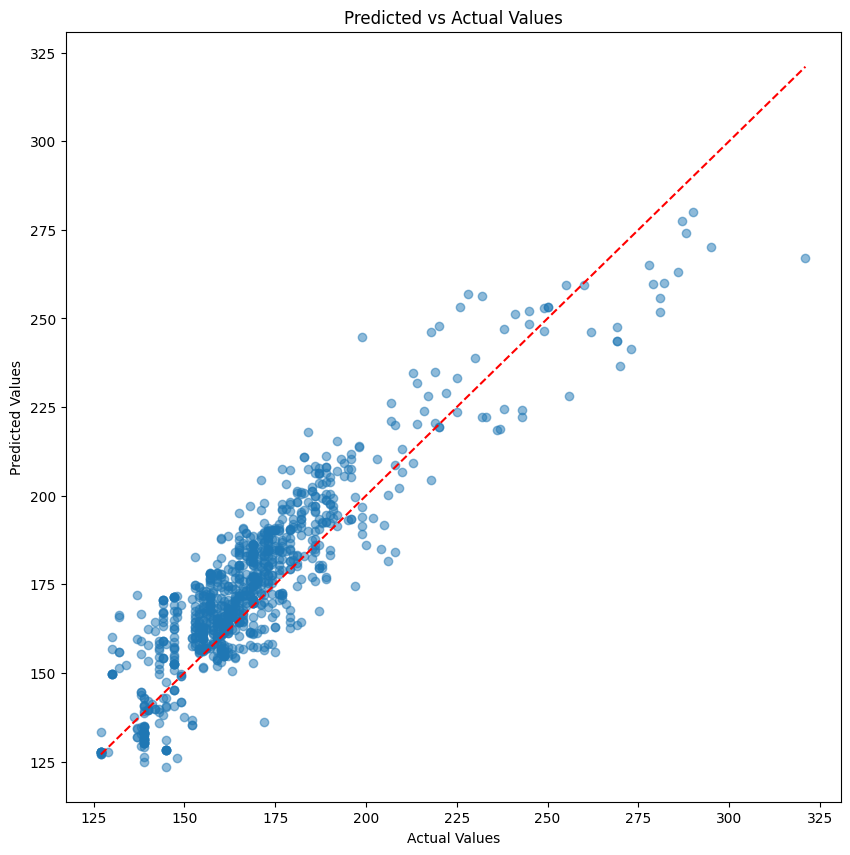

In [16]:
# Scatter Plot
# Plot predicted vs. actual values
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.show()

### Analyze residuals and their distribution

In [17]:
y_test.shape

(1000,)

In [18]:
y_pred.shape

(1000,)

In [19]:
residuals = y_test - y_pred

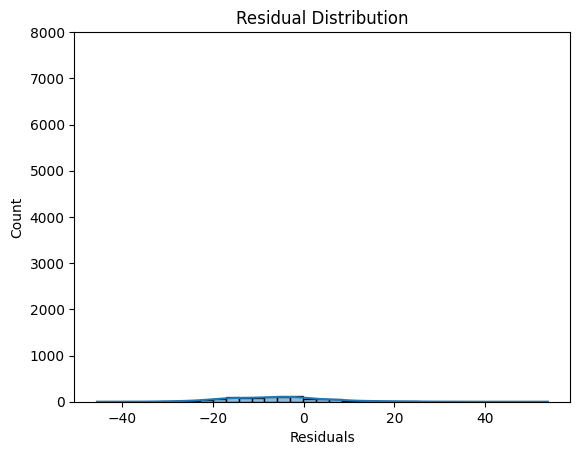

In [20]:
sns.histplot(residuals, kde=True)
plt.xlabel("Residuals")
plt.title("Residual Distribution")
plt.ylim([0, 8000])
plt.show()